In [1]:
from pathlib import Path
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm

/home/jgauthie/om2/miniconda/envs/huggingface/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# render the expensive figures?
RENDER_ALL_FIGURES = True

RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(exist_ok=True)

# save figures?
FIGURE_DIR = RESULTS_DIR / "figures"
FIGURE_DIR.mkdir(exist_ok=True)
SAVE_FIGURES = True

## Code suite metadata

In [3]:
# Format: suite_first_token -> [((expected_grammatical_region, expected_grammatical_condition),
#                                (expected_ungrammatical_region, expected_ungrammatical_condition), ...]
# 
# Will be used to compute margins between region-condition values.
# NB these are 1 greater than the region numbers in the SyntaxGym suites because each suite has an additional
# prefix region (possibly empty) at the start.

margin_measures = {
    "fgd_pp": [((8, "that_nogap"), (8, "what_nogap")),
               ((9, "what_gap"), (9, "that_gap"))],
    "fgd_subject": [((4, "that_nogap"), (4, "what_nogap")),
                    ((5, "what_gap"), (5, "that_gap"))],
    "fgd_object": [((6, "that_nogap"), (6, "what_nogap")),
                   ((7, "what_gap"), (7, "that_gap"))],

    "npi": [((9, "neg_pos"), (9, "pos_pos")),
            ((9, "neg_neg"), (9, "pos_neg")),
            ((9, "neg_pos"), (9, "pos_neg"))],

    # NB missing interaction term because we can't phrase it in this language
    "npz_obj": [((6, "no-obj_comma"), (6, "no-obj_no-comma")),
                ((6, "obj_no-comma"), (6, "no-obj_no-comma"))],
    "npz_obj_mod": [((7, "no-obj_comma"), (7, "no-obj_no-comma")),
                    ((7, "obj_no-comma"), (7, "no-obj_no-comma"))],
    
    "number_prep": [((7, "match_sing"), (7, "mismatch_sing")),
                    ((7, "match_plural"), (7, "mismatch_plural"))],
    "number_src": [((8, "match_sing"), (8, "mismatch_sing")),
                   ((8, "match_plural"), (8, "mismatch_plural"))],
    "number_orc": [((8, "match_sing"), (8, "mismatch_sing")),
                   ((8, "match_plural"), (8, "mismatch_plural"))],

    "reflexive_prep_fem": [((8, "match_sing"), (8, "mismatch_sing")),
                           ((8, "match_plural"), (8, "mismatch_plural"))],
    "reflexive_src_fem": [((9, "match_sing"), (9, "mismatch_sing")),
                          ((9, "match_plural"), (9, "mismatch_plural"))],
    "reflexive_orc_fem": [((9, "match_sing"), (9, "mismatch_sing")),
                          ((9, "match_plural"), (9, "mismatch_plural"))],
    "reflexive_prep_masc": [((8, "match_sing"), (8, "mismatch_sing")),
                            ((8, "match_plural"), (8, "mismatch_plural"))],
    "reflexive_src_masc": [((9, "match_sing"), (9, "mismatch_sing")),
                           ((9, "match_plural"), (9, "mismatch_plural"))],
    "reflexive_orc_masc": [((9, "match_sing"), (9, "mismatch_sing")),
                           ((9, "match_plural"), (9, "mismatch_plural"))],
    
    "subordination_src-src": [((6, "no-sub_no-matrix"), (6, "sub_no-matrix")),
                              ((6, "sub_matrix"), (6, "no-sub_matrix"))],
    "subordination_orc-orc": [((6, "no-sub_no-matrix"), (6, "sub_no-matrix")),
                              ((6, "sub_matrix"), (6, "no-sub_matrix"))],
    "subordination_pp-pp": [((6, "no-sub_no-matrix"), (6, "sub_no-matrix")),
                            ((6, "sub_matrix"), (6, "no-sub_matrix"))],
    
    "mvrr": [((6, "unreduced_ambig"), (6, "reduced_ambig")),
             ((6, "reduced_unambig"), (6, "reduced_ambig"))],
}

In [4]:
critical_regions = {suite: set(region for region_comparison in region_comparisons for region in region_comparison)
                    for suite, region_comparisons in margin_measures.items()}
critical_region_strs = {suite: {" ".join(map(str, region)) for region in regions} for suite, regions in critical_regions.items()}
critical_region_strs

{'fgd_pp': {'8 that_nogap', '8 what_nogap', '9 that_gap', '9 what_gap'},
 'fgd_subject': {'4 that_nogap', '4 what_nogap', '5 that_gap', '5 what_gap'},
 'fgd_object': {'6 that_nogap', '6 what_nogap', '7 that_gap', '7 what_gap'},
 'npi': {'9 neg_neg', '9 neg_pos', '9 pos_neg', '9 pos_pos'},
 'npz_obj': {'6 no-obj_comma', '6 no-obj_no-comma', '6 obj_no-comma'},
 'npz_obj_mod': {'7 no-obj_comma', '7 no-obj_no-comma', '7 obj_no-comma'},
 'number_prep': {'7 match_plural',
  '7 match_sing',
  '7 mismatch_plural',
  '7 mismatch_sing'},
 'number_src': {'8 match_plural',
  '8 match_sing',
  '8 mismatch_plural',
  '8 mismatch_sing'},
 'number_orc': {'8 match_plural',
  '8 match_sing',
  '8 mismatch_plural',
  '8 mismatch_sing'},
 'reflexive_prep_fem': {'8 match_plural',
  '8 match_sing',
  '8 mismatch_plural',
  '8 mismatch_sing'},
 'reflexive_src_fem': {'9 match_plural',
  '9 match_sing',
  '9 mismatch_plural',
  '9 mismatch_sing'},
 'reflexive_orc_fem': {'9 match_plural',
  '9 match_sing',
  '9

## Load results

In [5]:
OUTPUT_DIR = Path("output")

In [6]:
prediction_paths = list(OUTPUT_DIR.glob("*/*/*/*/predictions.csv"))
prediction_dfs = [pd.read_csv(path) for path in tqdm(prediction_paths)]
prediction_df_keys = [re.findall(r"([^/]+)/([^/]+)/([^/]+)/([^/]+)/predictions\.csv", str(path))[0]
                      for path in prediction_paths]
prediction_df = pd.concat(prediction_dfs, names=["model", "prefix_type", "suite", "prefix_suite"], keys=prediction_df_keys) \
    .drop(columns=["prefix_suite"])

# Drop duplicates
prediction_df = prediction_df[~prediction_df.index.duplicated(keep="first")]

  0%|          | 0/887 [00:00<?, ?it/s]

In [52]:
# Metadata variables that should be propagated from prediction_df to other derived and associated dfs
meta_vars = ["num_prefix_sentences", "prefix_length", "prefix_length_bin", "prefix_length_bin_left", "prefix_length_bin_mid", "prefix_length_bin_right",
             "canonical_suite", "suite_category", "item_number"]

prediction_cols = [key for key in prediction_df.columns if key.startswith("prediction_")]
prediction_df["prediction_ALL"] = prediction_df[prediction_cols].all(axis=1)
prediction_cols += ["prediction_ALL"]

prediction_df["first_item"] = prediction_df.used_item_numbers.str.split().str.get(0)

canonical_suite = {suite_name: next(can_suite for can_suite in critical_regions.keys()
                                    if can_suite in suite_name)
                   for suite_name in set(prediction_df.index.get_level_values("suite"))}

prediction_df["canonical_suite"] = prediction_df.index.get_level_values("suite").map(canonical_suite)
prediction_df["suite_category"] = prediction_df.canonical_suite.str.split("_").apply(lambda parts: "_".join(parts[:-1]) if len(parts) > 1 else parts[0])
prediction_df["critical_region"] = prediction_df.canonical_suite.map(critical_regions)

prediction_df["num_prefix_sentences"] = prediction_df.used_conditions.str.count(" ").fillna(0)
prefix_length_bin = pd.arrays.IntervalArray(pd.cut(prediction_df.prefix_length, 20))
prediction_df["prefix_length_bin_left"] = prefix_length_bin.left
prediction_df["prefix_length_bin_mid"] = prefix_length_bin.mid
prediction_df["prefix_length_bin_right"] = prefix_length_bin.right

prediction_df

item_number  \
model prefix_type   suite                 prefix_suite                              
gpt2  grammatical   fgd_object            fgd_object            0               1   
                                                                1               2   
                                                                2               3   
                                                                3               4   
                                                                4               5   
...                                                                           ...   
      ungrammatical subordination_src-src subordination_src-src 1943         1944   
                                                                1944         1945   
                                                                1945         1946   
                                                                1946         1947   
                                                                1947         1948   

                                                                      prediction_0  \
model prefix_type   suite                 prefix_suite                               
gpt2  grammatical   fgd_object            fgd_object            0             True   
                                                                1             True   
                                                                2             True   
                                                                3             True   
                                                                4             True   
...                                                                            ...   
      ungrammatical subordination_src-src subordination_src-src 1943          True   
                                                                1944          True   
                                                                1945          True   
                                                                1946          True   
                                                                1947          True   

                                                                      prediction_1  \
model prefix_type   suite                 prefix_suite                               
gpt2  grammatical   fgd_object            fgd_object            0             True   
                                                                1             True   
                                                                2             True   
                                                                3             True   
                                                                4             True   
...                                                                            ...   
      ungrammatical subordination_src-src subordination_src-src 1943          True   
                                                                1944          True   
                                                                1945          True   
                                                                1946          True   
                                                                1947          True   

                                                                                                      used_item_numbers  \
model prefix_type   suite                 prefix_suite                                                                    
gpt2  grammatical   fgd_object            fgd_object            0                                                     1   
                                                                1                                                     2   
                                                                2                                                     3   
                                                                3                                              

In [8]:
region_paths = list(OUTPUT_DIR.glob("*/*/*/*/regions.csv"))
region_dfs = [pd.read_csv(path) for path in tqdm(region_paths)]
region_df_keys = [re.findall(r"([^/]+)/([^/]+)/([^/]+)/([^/]+)/regions\.csv", str(path))[0]
                   for path in region_paths]
region_df = pd.concat(region_dfs, names=["model", "prefix_type", "suite", "prefix_suite"], keys=region_df_keys) \
    .drop(columns=["prefix_suite"])

  0%|          | 0/887 [00:00<?, ?it/s]

In [9]:
# Drop duplicates
region_df = region_df[~region_df.index.duplicated(keep="first")]

# Bring in metadata from predictions df
region_df = pd.merge(region_df.reset_index(), prediction_df[meta_vars].reset_index(),
                     on=["model", "prefix_type", "suite", "prefix_suite", "item_number"])

region_df

,model,prefix_type,suite,prefix_suite,level_4_x,item_number,value,condition,region_number,level_4_y,num_prefix_sentences,prefix_length,prefix_length_bin,canonical_suite,suite_category
0,gpt2,grammatical,fgd_object,fgd_object,0,1,8.975654,what_nogap,2,0,0.0,0,"(-0.54, 27.0]",fgd_object,fgd
1,gpt2,grammatical,fgd_object,fgd_object,1976,1,4.586143,what_nogap,3,0,0.0,0,"(-0.54, 27.0]",fgd_object,fgd
2,gpt2,grammatical,fgd_object,fgd_object,3952,1,26.174854,what_nogap,4,0,0.0,0,"(-0.54, 27.0]",fgd_object,fgd
3,gpt2,grammatical,fgd_object,fgd_object,5928,1,16.165907,what_nogap,5,0,0.0,0,"(-0.54, 27.0]",fgd_object,fgd
4,gpt2,grammatical,fgd_object,fgd_object,7904,1,16.567860,what_nogap,6,0,0.0,0,"(-0.54, 27.0]",fgd_object,fgd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58491113,gpt2,ungrammatical,subordination_src-src,subordination_src-src,38959,1948,50.520851,no-sub_matrix,6,1947,24.0,492,"(486.0, 513.0]",subordination_src-src,subordination
58491114,gpt2,ungrammatical,subordination_src-src,subordination_src-src,40907,1948,2346.938721,sub_no-matrix,1,1947,24.0,492,"(486.0, 513.0]",subordination_src-src,subordination
58491115,gpt2,ungrammatical,subordination_src-src,subordination_src-src,42855,1948,2346.938721,no-sub_no-matrix,1,1947,24.0,492,"(486.0, 513.0]",subordination_src-src,subordination
58491116,gpt2,ungrammatical,subordination_src-src,subordination_src-src,44803,1948,2346.938721,sub_matrix,1,1947,24.0,492,"(486.0, 513.0]",subordination_src-src,subordination


In [10]:
sns.set_context("talk")

In [11]:
prefix_types = prediction_df.index.get_level_values("prefix_type").unique()

## Prediction results

In [12]:
# Get baseline accuracy results.
baseline_accuracies = prediction_df[prediction_df.used_conditions.isna()] \
    [prediction_cols + ["canonical_suite"]] \
    .melt(id_vars=["canonical_suite"]).groupby(["canonical_suite", "variable"]).value.mean().dropna()
baseline_accuracies

canonical_suite        variable      
fgd_object             prediction_0      1.000000
                       prediction_1      0.958333
                       prediction_ALL    0.958333
fgd_pp                 prediction_0      0.916667
                       prediction_1      0.958333
                       prediction_ALL    0.875000
fgd_subject            prediction_0      0.625000
                       prediction_1      0.875000
                       prediction_ALL    0.500000
mvrr                   prediction_0      1.000000
                       prediction_1      0.855357
                       prediction_2      0.787054
                       prediction_ALL    0.766964
npi                    prediction_0      0.993120
                       prediction_1      0.972996
                       prediction_2      0.870829
                       prediction_ALL    0.863949
npz_obj                prediction_0      1.000000
                       prediction_1      1.000000
            

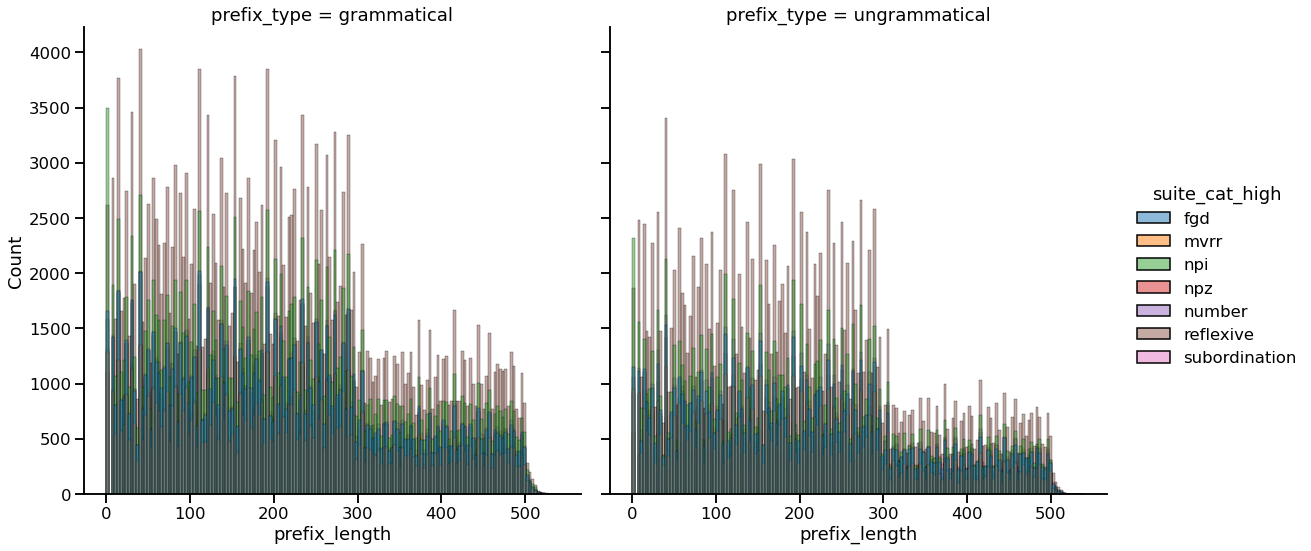

In [13]:
sns.displot(data=prediction_df.assign(suite_cat_high=prediction_df.suite_category.str.split("_").str[0]).reset_index(),
            x="prefix_length", hue="suite_cat_high", col="prefix_type", height=8)

In [53]:
prediction_df_melt = prediction_df.reset_index()
prediction_df_melt = prediction_df_melt.loc[:, prediction_df_melt.columns.str.startswith(("model", "prediction", "prefix_type", "prefix_suite") + tuple(meta_vars))] \
    .melt(id_vars=meta_vars + ["model", "prefix_type", "prefix_suite"], var_name="prediction", value_name="correct")
prediction_df_melt

,num_prefix_sentences,prefix_length,prefix_length_bin,prefix_length_bin_left,prefix_length_bin_mid,prefix_length_bin_right,canonical_suite,suite_category,item_number,model,prefix_type,prefix_suite,prediction,correct
0,0.0,0,"(-0.54, 27.0]",-0.54,13.23,27.0,fgd_object,fgd,1,gpt2,grammatical,fgd_object,prediction_0,True
1,0.0,0,"(-0.54, 27.0]",-0.54,13.23,27.0,fgd_object,fgd,2,gpt2,grammatical,fgd_object,prediction_0,True
2,0.0,0,"(-0.54, 27.0]",-0.54,13.23,27.0,fgd_object,fgd,3,gpt2,grammatical,fgd_object,prediction_0,True
3,0.0,0,"(-0.54, 27.0]",-0.54,13.23,27.0,fgd_object,fgd,4,gpt2,grammatical,fgd_object,prediction_0,True
4,0.0,0,"(-0.54, 27.0]",-0.54,13.23,27.0,fgd_object,fgd,5,gpt2,grammatical,fgd_object,prediction_0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7053043,24.0,495,"(486.0, 513.0]",486.00,499.50,513.0,subordination_src-src,subordination,1944,gpt2,ungrammatical,subordination_src-src,prediction_ALL,True
7053044,24.0,490,"(486.0, 513.0]",486.00,499.50,513.0,subordination_src-src,subordination,1945,gpt2,ungrammatical,subordination_src-src,prediction_ALL,True
7053045,24.0,475,"(459.0, 486.0]",459.00,472.50,486.0,subordination_src-src,subordination,1946,gpt2,ungrammatical,subordination_src-src,prediction_ALL,True
7053046,24.0,483,"(459.0, 486.0]",459.00,472.50,486.0,subordination_src-src,subordination,1947,gpt2,ungrammatical,subordination_src-src,prediction_ALL,True


In [57]:
# Compute average accuracies per model/prefix suite/suite/prefix type/prediction/prefix length bin.
prediction_summaries = pd.DataFrame(prediction_df_melt.dropna().groupby(["model", "prefix_type", "canonical_suite", "prefix_suite", "prefix_length_bin_mid", "prediction"]).correct.mean())
# Merge in baseline information.
merged = pd.merge(prediction_summaries, baseline_accuracies.rename("baseline_accuracy").rename_axis(index={"variable": "prediction"}),
                  left_index=True, right_index=True, how="outer")
assert len(merged) == len(prediction_summaries)
prediction_summaries = merged.reset_index()

In [58]:
prediction_summaries["baselined"] = prediction_summaries.correct - prediction_summaries.baseline_accuracy
prediction_summaries["in_domain"] = prediction_summaries.prefix_suite == prediction_summaries.canonical_suite
prediction_summaries["strategy"] = prediction_summaries.prefix_type.str.cat(prediction_summaries.in_domain.map({True: "in-domain", False: "out-of-domain"}), sep=" ")
prediction_summaries

,canonical_suite,prediction,model,prefix_type,prefix_suite,prefix_length_bin_mid,correct,baseline_accuracy,baselined,in_domain,strategy
0,fgd_object,prediction_0,gpt2,grammatical,fgd_object,13.23,1.000000,1.0,0.000000,True,grammatical in-domain
1,fgd_object,prediction_0,gpt2,grammatical,fgd_object,40.50,1.000000,1.0,0.000000,True,grammatical in-domain
2,fgd_object,prediction_0,gpt2,grammatical,fgd_object,67.50,1.000000,1.0,0.000000,True,grammatical in-domain
3,fgd_object,prediction_0,gpt2,grammatical,fgd_object,94.50,1.000000,1.0,0.000000,True,grammatical in-domain
4,fgd_object,prediction_0,gpt2,grammatical,fgd_object,121.50,1.000000,1.0,0.000000,True,grammatical in-domain
...,...,...,...,...,...,...,...,...,...,...,...
36139,subordination_src-src,prediction_ALL,gpt2,ungrammatical,subordination_src-src,418.50,0.788462,1.0,-0.211538,True,ungrammatical in-domain
36140,subordination_src-src,prediction_ALL,gpt2,ungrammatical,subordination_src-src,445.50,0.621359,1.0,-0.378641,True,ungrammatical in-domain
36141,subordination_src-src,prediction_ALL,gpt2,ungrammatical,subordination_src-src,472.50,0.600000,1.0,-0.400000,True,ungrammatical in-domain
36142,subordination_src-src,prediction_ALL,gpt2,ungrammatical,subordination_src-src,499.50,0.538462,1.0,-0.461538,True,ungrammatical in-domain


In [67]:
prediction_summaries[prediction_summaries.in_domain].groupby(["strategy", "prefix_length_bin_mid"]).size()

strategy                 prefix_length_bin_mid
grammatical in-domain    13.23                    53
                         40.50                    53
                         67.50                    53
                         94.50                    53
                         121.50                   53
                         148.50                   53
                         175.50                   53
                         202.50                   53
                         229.50                   53
                         256.50                   53
                         283.50                   53
                         310.50                   41
                         337.50                   26
                         364.50                   26
                         391.50                   26
                         418.50                   26
                         445.50                   26
                         472.50                   26

(array([-100.,    0.,  100.,  200.,  300.,  400.,  500.,  600.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

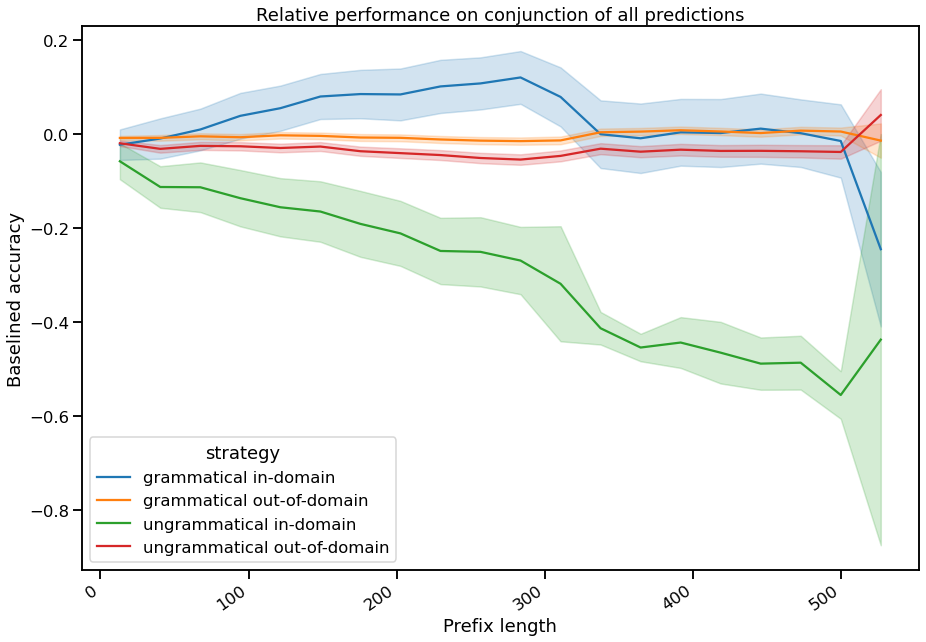

In [71]:
plt.subplots(figsize=(15, 10))
ax = sns.lineplot(data=prediction_summaries[prediction_summaries.prediction == "prediction_ALL"],
                  x="prefix_length_bin_mid", y="baselined", hue="strategy", errorbar="se")
plt.ylabel("Baselined accuracy")
plt.xlabel("Prefix length")
plt.title("Relative performance on conjunction of all predictions")
plt.xticks(rotation=35, ha="right")

# in_domain_prefixes = prediction_df_melt[prediction_df_melt.prefix_suite == prediction_df_melt.canonical_suite]
# sns.lineplot(data=in_domain_prefixes, x="prefix_length_bin", y="correct", errorbar="se")

### By-suite results

In [ ]:
if RENDER_ALL_FIGURES:
    g = sns.FacetGrid(data=prediction_df_melt, height=8, row="canonical_suite", col="prefix_suite")
    g.map(sns.lineplot, "num_prefix_sentences", "correct", "prediction")
    g.add_legend()

    plt.xlabel("# prefix sentences")
    plt.ylabel("Prediction accuracy")
    
    if SAVE_FIGURES:
        g.savefig(FIGURE_DIR / "prediction_accuracy.num_prefix_sentences.pdf")
        plt.close()

In [ ]:
# Too noisy. Use binned plot instead.
# sns.lineplot(data=prediction_df, x="prefix_length", y="prediction_0")

# plt.xlabel("# prefix tokens")
# plt.ylabel("Prediction accuracy")

In [ ]:
if RENDER_ALL_FIGURES:
    g = sns.FacetGrid(data=prediction_df_melt, height=8, row="canonical_suite", col="prefix_suite")
    g.map(sns.lineplot, "prefix_length_bin", "correct", "prediction")
    g.add_legend()

    for ax in g.axes.ravel():
        ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha="right")

    plt.xlabel("# prefix tokens (binned)")
    plt.ylabel("Prediction accuracy")
    
    if SAVE_FIGURES:
        g.savefig(FIGURE_DIR / "prediction_accuracy.prefix_length_bin.pdf")
        plt.close()

## Cross-suite prefixing analysis

In [ ]:
def get_best_prediction_performance(prefixed_suite):
    return prefixed_suite.groupby("num_prefix_sentences")[prediction_cols].mean().max()
cross_perfs = prediction_df.groupby(["prefix_type", "suite", "prefix_suite"]).apply(get_best_prediction_performance)
cross_perfs

In [ ]:
def plot_cross_perfs(cross_perfs: pd.DataFrame, **kwargs):
    cross_perfs = cross_perfs.sort_index(axis=0).sort_index(axis=1)
    f, axs = plt.subplots(len(prediction_cols), 1, figsize=(25, 30))
    for ax, col_name in zip(axs, prediction_cols):
        sns.heatmap(cross_perfs[col_name].unstack(), ax=ax, annot=True, **kwargs)
        ax.set_title(col_name)
    plt.tight_layout()
    return f, axs

In [ ]:
f, axs = plot_cross_perfs(cross_perfs)
f.suptitle("Cross-suite performance\nat any prefix length")
plt.tight_layout()

if SAVE_FIGURES:
    f.savefig(FIGURE_DIR / "cross_suite.max.pdf")

### Redo with matched lengths

In [ ]:
# Pick the minimum number of prefix sentences for which all suite/prefix-suite combinations have data
max_sentences = prediction_df.groupby(["suite", "prefix_suite"]).num_prefix_sentences.max().min()
print(max_sentences)

cross_perfs_maxlen = prediction_df.groupby(["suite", "prefix_suite"]).apply(lambda xs: xs.loc[xs.num_prefix_sentences == max_sentences, prediction_cols].mean())
cross_perfs_maxlen.head()

In [ ]:
f, axs = plot_cross_perfs(cross_perfs_maxlen)
f.suptitle("Cross-suite performance\nat a single prefix length which is compatible for all prefixes")
plt.tight_layout()

if SAVE_FIGURES:
    f.savefig(FIGURE_DIR / f"cross_suite.len-{int(max_sentences)}.pdf")

### Plot changes from baseline rather than absolute accuracy, at maximum and at matched lengths

In [ ]:
baseline_perfs = prediction_df[prediction_df.prefix_length == 0].reset_index().groupby("suite").apply(lambda xs: xs[xs.prefix_suite == xs.suite][prediction_cols].mean())
baseline_perfs

In [ ]:
def get_best_prediction_improvement_pct(rows, matched_lengths=True):
    suite, prefixed_suite = rows.name
    
    if matched_lengths:
        rows = rows[rows.num_prefix_sentences == max_sentences]
    mean_perfs = rows.groupby("num_prefix_sentences")[prediction_cols].mean()
    
    try:
        baseline_perf = baseline_perfs.loc[suite]
    except KeyError:
        baseline_perf = np.nan
        
    diff_of_means = mean_perfs - baseline_perf
    max_diff = diff_of_means.max()
    return max_diff / baseline_perf * 100

In [ ]:
cross_improvement_pcts = prediction_df.groupby(["suite", "prefix_suite"]).apply(get_best_prediction_improvement_pct, matched_lengths=False)
f, axs = plot_cross_perfs(cross_improvement_pcts, center=0, cmap="seismic")

if SAVE_FIGURES:
    f.savefig(FIGURE_DIR / f"cross_suite_pcts.max.pdf")

In [ ]:
cross_improvement_pcts_maxlen = prediction_df.groupby(["suite", "prefix_suite"]).apply(get_best_prediction_improvement_pct)
f, axs = plot_cross_perfs(cross_improvement_pcts_maxlen, center=0, cmap="seismic")

if SAVE_FIGURES:
    f.savefig(FIGURE_DIR / f"cross_suite_pcts.len-{int(max_sentences)}.pdf")

In [ ]:
sns.clustermap(cross_improvement_pcts["prediction_ALL"].unstack())

## Margins

In [ ]:
def filter_critical_regions(suite_df):
    critical_strs = critical_region_strs[suite_df.canonical_suite.iloc[0]]
    is_critical = suite_df.region_number.astype(str).str.cat(suite_df.condition, " ").isin(critical_strs)
    return suite_df[is_critical]

critical_region_df = region_df.groupby(["suite", "canonical_suite"], as_index=False) \
    .apply(filter_critical_regions)
critical_region_df

In [ ]:
if RENDER_ALL_FIGURES:
    g = sns.FacetGrid(data=critical_region_df, height=8, row="canonical_suite", col="prefix_suite", sharey=False)
    g.map(sns.lineplot, "prefix_length_bin", "value", "condition")
    for ax in g.axes.ravel():
        ax.legend()

    plt.xticks(rotation=35)
    plt.legend(loc=(1.04,0))
    plt.xlabel("# prefix tokens (binned)")
    plt.ylabel("Raw surprisal")
    
    if SAVE_FIGURES:
        g.savefig(FIGURE_DIR / "surprisal.prefix_length_bin.pdf")
        plt.close()

In [ ]:
# g = sns.catplot(data=critical_region_df, x="num_prefix_sentences", y="value", hue="condition", alpha=0.1,
#                 height=10)
# sns.lineplot(data=critical_region_df, x="num_prefix_sentences", y="value", hue="condition", ax=g.ax, legend=False)

# plt.legend(loc=(1.04,0))
# plt.xlabel("# prefix sentences")
# plt.ylabel("Raw surprisal")

In [ ]:
def compute_margins(rows):
    margin_spec = margin_measures[rows.iloc[0].canonical_suite]
    rows = rows.set_index(["region_number", "condition"]).value
    
    margins = pd.Series([rows.loc[ungrammatical] - rows.loc[grammatical]
                         for grammatical, ungrammatical in margin_spec])
    return margins

margin_sizes = critical_region_df.groupby(["suite", "prefix_suite", "item_number"]).apply(compute_margins)
margin_sizes = pd.merge(margin_sizes.reset_index(), prediction_df[meta_vars].reset_index(),
                        on=["suite", "prefix_suite", "item_number"])
margin_sizes

In [ ]:
# Prefer binned figure below.

# sns.lineplot(data=margin_sizes.melt(id_vars=["prefix_length"], value_vars=["sing", "plur"], var_name="Prediction"),
#              x="prefix_length", y="value", hue="Prediction")

# plt.legend(loc=(1.04, 0))
# plt.axhline(0, color="gray", linestyle="--")
# plt.xlabel("# prefix tokens")
# plt.ylabel("Grammaticality margin (bits)")

In [ ]:
if RENDER_ALL_FIGURES:
    margin_sizes["prefix_length_bin"] = pd.cut(margin_sizes.prefix_length, 10).astype(str)
    to_plot = margin_sizes.melt(id_vars=meta_vars + ["prefix_suite"],
                                value_vars=[0, 1], var_name="Prediction")
    g = sns.catplot(data=to_plot, row="canonical_suite", col="prefix_suite",
                    x="prefix_length_bin", y="value", hue="Prediction", alpha=0.1, height=8)
    g.map(sns.lineplot, "prefix_length_bin", "value", "Prediction")

    for ax in g.axes.flat:
        ax.axhline(0, color="gray", linestyle="--")
        ax.set_xticks(ax.get_xticks(), rotation=35)
        ax.set_xlabel("# prefix tokens (binned)")
        ax.set_ylabel("Grammaticality margin (bits)")
        
    if SAVE_FIGURES:
        g.savefig(FIGURE_DIR / "margins.prefix_length_bin.pdf")
        plt.close()

In [ ]:
# # DEV recompute predictions as a sanity check
# recompute_preds = margin_sizes.assign(**{f"correct_{idx}": margin_sizes[idx] > 0
#                                          for idx in [col for col in margin_sizes.columns if isinstance(col, int)]})

In [ ]:
# sns.lineplot(data=recompute_preds[["prefix_length_bin", "correct_0", "correct_1"]].melt(id_vars=["prefix_length_bin"]),
#              x="prefix_length_bin", y="value", hue="variable")

In [ ]:
# # recompute_preds[recompute_preds.prefix_length == 0].groupby("canonical_suite").correct.mean()
# recompute_preds[recompute_preds.prefix_length == 0][["correct_0", "correct_1"]].melt().groupby("variable").value.mean()

## Total probability margins

In [ ]:
total_surprisals = region_df.groupby(["suite", "canonical_suite", "prefix_suite", "item_number", "condition"]).value.sum().reset_index()
total_surprisals

In [ ]:
def compute_margins(rows):
    margin_spec = margin_measures[rows.iloc[0].canonical_suite]
    rows = rows.set_index(["condition"]).value
    return pd.Series([rows.loc[ungrammatical_cond] - rows.loc[grammatical_cond]
                      for (_, grammatical_cond), (_, ungrammatical_cond) in margin_spec])

total_surprisal_margins = total_surprisals.groupby(["suite", "prefix_suite", "item_number"]).apply(compute_margins)
total_surprisal_margins

In [ ]:
# Bring back metadata
total_surprisal_margins = pd.merge(total_surprisal_margins.reset_index(), prediction_df[meta_vars].reset_index(),
                                   on=["suite", "prefix_suite", "item_number"])

In [ ]:
if RENDER_ALL_FIGURES:
    to_plot = total_surprisal_margins.melt(id_vars=["prefix_length_bin", "canonical_suite", "prefix_suite"],
                                           value_vars=[0, 1], var_name="Prediction")
    g = sns.catplot(data=to_plot, row="canonical_suite", col="prefix_suite",
                    x="prefix_length_bin", y="value", hue="Prediction", alpha=0.1, height=8)
    g.map(sns.lineplot, "prefix_length_bin", "value", "Prediction")

    for ax in g.axes.flat:
        ax.axhline(0, color="gray", linestyle="--")
        ax.set_xticks(ax.get_xticks(), rotation=35)
        ax.set_xlabel("# prefix tokens (binned)")
        ax.set_ylabel("Grammaticality margin (bits)")
        
    if SAVE_FIGURES:
        g.savefig(FIGURE_DIR / "total_surprisal_margin.prefix_length_bin.pdf")
        plt.close()

## Save results data

In [ ]:
prediction_df.to_csv(RESULTS_DIR / "predictions.csv")
# region_df.to_csv(RESULTS_DIR / "regions.csv", index=False)

cross_perfs.to_csv(RESULTS_DIR / "cross_suite.max.csv")
cross_perfs_maxlen.to_csv(RESULTS_DIR / f"cross_suite.len-{int(max_sentences)}.csv")
cross_improvement_pcts.to_csv(RESULTS_DIR / "cross_suite_pcts.max.csv")
cross_improvement_pcts_maxlen.to_csv(RESULTS_DIR / f"cross_suite_pcts.len-{int(max_sentences)}.csv")

In [ ]:
# critical_region_df.to_csv(RESULTS_DIR / "critical_regions.csv")
margin_sizes.to_csv(RESULTS_DIR / "margins.csv")
total_surprisals.to_csv(RESULTS_DIR / "total_surprisals.csv")
total_surprisal_margins.to_csv(RESULTS_DIR / "total_surprisal_margins.csv")